---
title: "03: Image Classification and Interpretation"
author: "Thomas Manke"
date:  "2024-01-05"
categories:
  - CNN
  - Tensorflow/Keras
  - Grad-CAM
  - Interpretation
  - Activation Maps
format:
  html:
    code-fold: true
description: "**Ziel**: Benutze und Interpretiere Deep Neural Networks"
image: "images/Sherlock.png"
---

# 1. Lade Libraries

Im Folgenden benutzen wir die Tensorflow/Keras Software Plattform. Eine bekannte Alternative ist pyTorch.

Beide Softwareloesungen kommen mit einem breiten Funktionsspektrum und ermöglichen auch die Benutzung von GPU.  

GPU sind für das aufwendige Training grosser Neuraler Netzwerke unabdingbar. Hier werden wir nicht trainieren und können mit normalen CPU arbeiten.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# convenience functions
def top_pred(preds, ntop=5):
    """
    Generate barplot of proabilities for best class predictions and 
    return top class (index, name, probability)
    """
    # decode top predicitions (class_name and probabilities)
    decoded_predictions = decode_predictions(preds, top=ntop)[0]

    # Extract class names, probabilities and indices
    class_names = [label[1] for label in decoded_predictions]
    class_probs = [label[2] for label in decoded_predictions]
    class_inds  = np.argsort(preds[0])[::-1][:ntop]

    # define top class [id, name, prob] 
    top_class = [class_inds[0], class_names[0], class_probs[0]]

    fig, ax = plt.subplots()
    bars = ax.barh(class_inds.astype(str), class_probs)
    ax.set_xlabel('Class Probability')
    ax.set_ylabel('Class ID')
    ax.set_title('Top Predictions')

    # Add class names
    for bar, id in zip(bars, class_names):
        ax.text(bar.get_width()/2, bar.get_y() + bar.get_height() / 2, f'{id}', va='center')

    plt.show()

    return top_class

def plot_layer(x, model, layer, channels=(0,1,2)):
  """ 
  For a given input image x, CNN model, and specified layer
  plot the activartion of selected channels (default: (0,1,2))
  """
  output = model.layers[layer].output                          # define output from layer                     
  fmodel = tf.keras.Model(inputs=model.inputs, outputs=output) # model only up to layer
  amap   = fmodel.predict(x)                                   # activation map = feature map

  print('layer: {} name: {} activation_map: {}'.format(layer, model.layers[layer].name, amap.shape))
  fig, ax = plt.subplots(nrows=1, ncols=len(channels), figsize=(12, 16))

  ix = 0
  for c in channels:
    ax[ix].imshow(amap[0, :, :, c], cmap='gray')
    ix = ix + 1
  plt.show()


In [5]:
%%script echo "install tf-keras-vis if not yet in the environment"
# not yet installed on google-colab
! pip install tf-keras-vis

install tf-keras-vis if not yet in the environment


# 2. Lade Model (optimiert)

Ein klassisches Model ist **Vgg16**. Es wurde mit 14 Millionen Bildern ('ImageNet') aus 1000 Kategorien trainiert ('ImageNet') 

Computezeit: >3 Wochen mit 4 GPU!!!

![Vgg16. Illustration from paperswithcode.com](images/Vgg16.png)

Andere vortrainierte Modelle sind hier verfügbar: [https://keras.io/api/applications/](https://keras.io/api/applications/) 

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
model = VGG16()
model.summary()

2024-01-23 22:09:35.970770: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 3. Lade Daten

**Beachte**

- Benutze Daten genau so wie vom Modell erwartet: reshape, convert, scale, normalize. $\to$ Keras functions: *image.load_img*,  *preprocess_input*.

- *decode_prediction* wird später helfen die labels (1-1000) in Kategorien zu übersetzen

input_size: (224, 224)


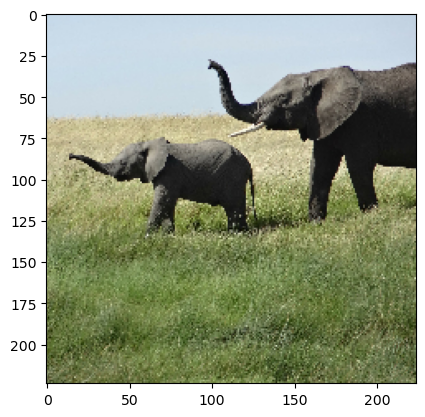

In [7]:
# load more convenience functions
from keras.preprocessing import image


# choose your jpeg file
fn='images/elephant.jpg'
url='https://img-datasets.s3.amazonaws.com/elephant.jpg'
#fn=tf.keras.utils.get_file(origin=url)

# determine target size of image
input_shape = model.input_shape                  # input shape is (,w,h,3)
input_size  = (input_shape[1], input_shape[2])   # expected size of input images (w x h)
print('input_size:',input_size)

# load image (with proper size)
img = image.load_img(fn, target_size=input_size, keep_aspect_ratio=True)
plt.imshow(img)
plt.show()

# data conversions and preprocessing
x = image.img_to_array(img)  # PIL -> numpy
x = x[np.newaxis, ...]       # expand to sample dimension, np.expand_dims(x, axis=0)
x = preprocess_input(x)      # preprocess as was done for Vgg16

# 4. Predictions

1/1 [==============================] - 1s 519ms/step


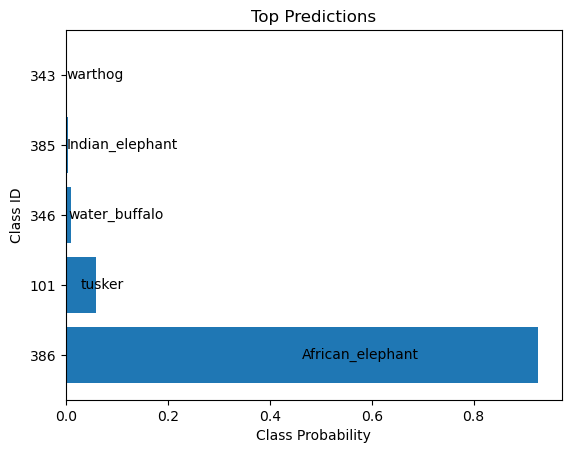

In [8]:
preds = model.predict(x)
top_class = top_pred(preds)

## Einfach und schnell: Software + Model + Daten $\to$ Predict

## Wie gut sind die Vorhersagen ?

![Accuracy on ImageNet: improvements of the bests. Source: https://paperswithcode.com/](images/ImageNet_acc.png)

Human performance can be tested here: [https://cs.stanford.edu/people/karpathy/ilsvrc/](https://cs.stanford.edu/people/karpathy/ilsvrc/)

## Woher kommt der Erfolg ?

- Data Power: Big Data + Annotations
- Compute Power: GPU
- Brain Power: clever training algorithms
- Software Power: Standardisierung & Modularizierung (Legoprinzip: plug-n-play)
- Social Power: open source community, training materials, friendly competitions

# 5. Interpretation

## 5.1 Visualize Outputs: Activation Maps

Hier schauen wir uns die Aktivierungsmuster der verschiedenen Ebenen im CNN an.

Intuition:

- Frühe Layers messen basale Strukturen und features (Linien etc.)
- Tiefere Layer "erkennen" Konzepte

1/1 [==============================] - 0s 48ms/step
layer: 1 name: block1_conv1 activation_map: (1, 224, 224, 64)


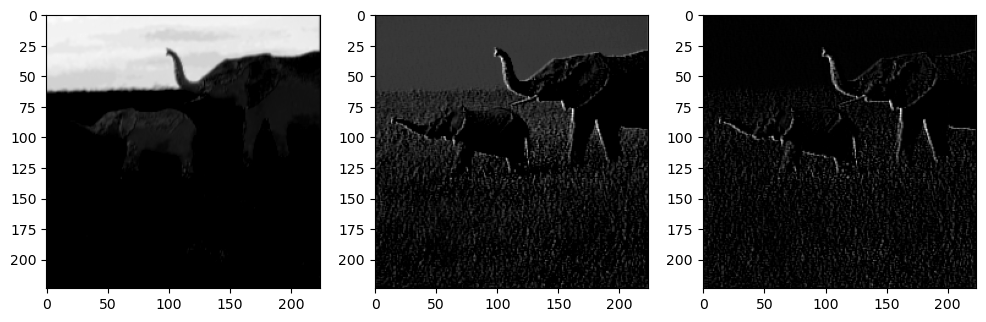

1/1 [==============================] - 0s 188ms/step
layer: 17 name: block5_conv3 activation_map: (1, 14, 14, 512)


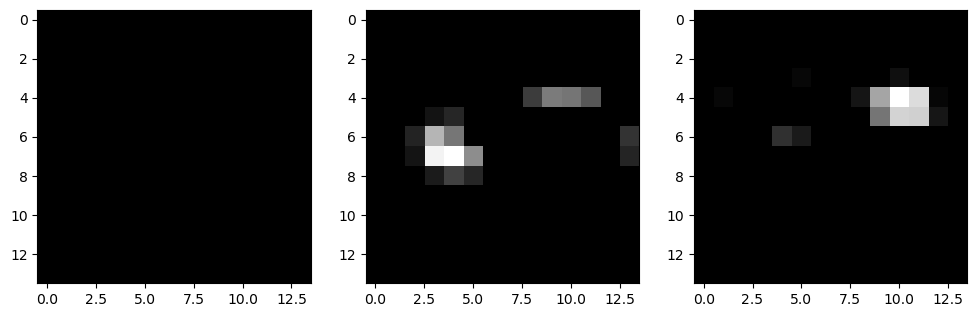

In [9]:
plot_layer(x, model, layer=1,channels=(1,2,63))
plot_layer(x, model, layer=17, channels=(1,2,511))

## 5.2 Summarizing Activation Maps

Welche Veränderungen in den Daten (X) haben den größten Einfluss auf die gemachte Vorhersage (class="African Elephant").

![1 Frage - 2 Methoden: Welche Pixel sind für die Klassenvorhersage wichtig?](images/interpretation.jpg)

## 5.3 Anwendung

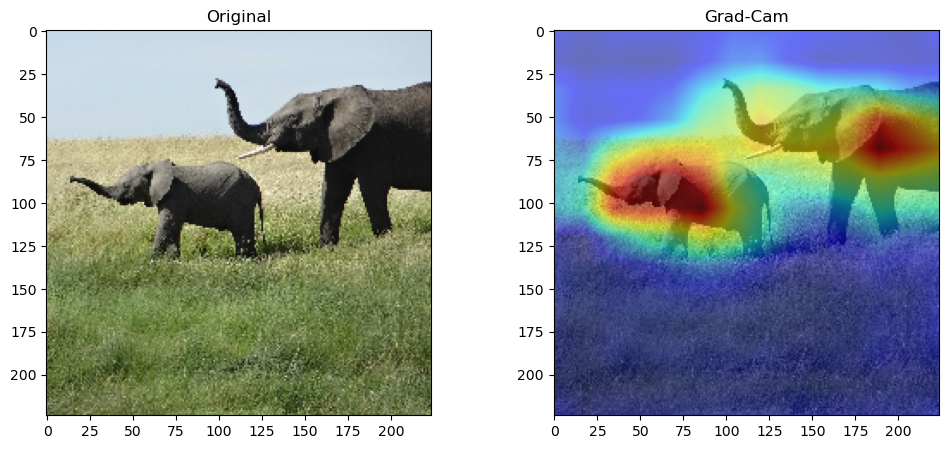

In [10]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# get predicted label (class id)
top_class_id = top_class[0]
# get score of predicted label: y_c
score = CategoricalScore([top_class_id])
# gradcam object
gradcam = GradcamPlusPlus( model, model_modifier=ReplaceToLinear(), clone=True)
# 2D array of same size as x \in [0,1]
cam     = gradcam(score, x) 
# convert heatmap (RGB), ignore transparency, convert to int
heatmap = np.uint8(plt.cm.jet(cam[0])[..., :3] * 255)

# plot and overlay
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')

ax = plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5) 
plt.title('Grad-Cam')

plt.show()

## 5.4 Nutzen von Visualisierungen (Grad-CAM)

- Interpretation von Vorhersagen (e.g. radiology: direct attention)
- Verständnis von Misklassifizierungen (e.g. bias detection)

![Grad-CAM on biased and unbiased networks](https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs11263-019-01228-7/MediaObjects/11263_2019_1228_Fig8_HTML.png)

# 6. Erweiterungen

- Bild Interpretation $\to$ Modell Interpretation
    - maximal activation of neuron: Activation Maximation
- Quantifying Interpretabiltiy
    - Network dissection: Überlapp von deep Neuronen mit Konzepten

# 7. Summary & Outlook

- viele tools & einfache Benutzung
- combined power & collective effort: Daten, Algorithmen, GPUs, people
- beyond black-box accuracy: Interpretierbarkeit, Robustheit, Sicherheit
- beyond image classification $\to$ segmentation

# References

- Vgg16: [Simonyan & Zisserman](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Grad-CAM: [Selvaraju et al. (2019)](https://link.springer.com/article/10.1007/s11263-019-01228-7)
- Performance Evaluations: [https://paperswithcode.com/](https://paperswithcode.com/)
- Testing Human Performance: [https://cs.stanford.edu/people/karpathy/ilsvrc/](https://cs.stanford.edu/people/karpathy/ilsvrc/)
- Interpretation of Predictions: [Interpretable Machine Learning (2023)](https://christophm.github.io/interpretable-ml-book/index.html)
